In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/HW3/lfw.zip" "/content/"


In [ ]:
import zipfile
with zipfile.ZipFile("/content/lfw.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
path = 'lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

MPS device not found.
GPU not available. Using CPU.


torch.Size([250, 250, 3])


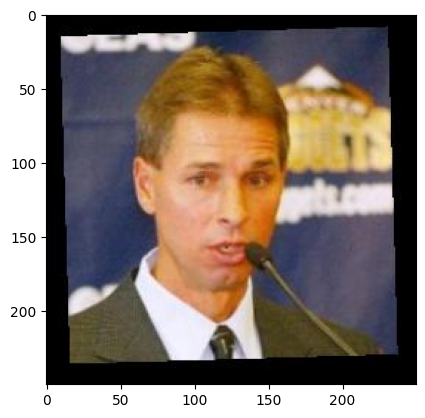

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

Ans:- Height (250): This dimension corresponds to the number of pixels along the vertical axis of the image i.e 250 pixels.

Width (250):
This dimension corresponds to the number of pixels along the horizontal axis of the image i.e 250 pixels.


Channels (3):
This dimension represents the number of color channels in the image. In the context of the given tensor, it's 3, which typically corresponds to the RGB (Red, Green, Blue) color channels. Each pixel in the image is represented by a combination of these three color channels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [ ]:
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Sigmoid for output in [0, 1]
        )

    def encoder(self, x):
        return self.encoder_conv(x)

    def decoder(self, x):
        return self.decoder_conv(x)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [ ]:
model = AE()

In [ ]:
input_image = x.permute(2, 0, 1).unsqueeze(0)

# Pass the input image through the model
output = model(input_image)

# Print the shape of the output of the encoder
encoded_output = model.encoder(input_image)
print("Encoder Output Shape:", encoded_output.shape)

# Print the shape of the output of the decoder
decoded_output = model.decoder(encoded_output)
print("Decoder Output Shape:", decoded_output.shape)

Encoder Output Shape: torch.Size([1, 128, 32, 32])
Decoder Output Shape: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for

Ans:- A common choice for image reconstruction in autoencoders is the Mean Squared Error (MSE) loss. It measures the average squared difference between the input and the reconstructed output.

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters: {total_params}")

Total Number of Parameters: 186371


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

Ans:- To troubleshoot a non-decreasing loss, first, we can check and adjust the learning rate. Ensure the model complexity aligns with the data and look out for outliers or noisy samples.We can also verify proper preprocessing and normalization of data. Experiment with hyperparameters and consider regularization techniques like dropout. If needed, we can also increase model capacity or train for more epochs cautiously to prevent overfitting.

In [ ]:
import torch.nn.functional as F

num_epochs = 5  # Set the number of epochs

for epoch in range(num_epochs):
    total_loss = 0.0

    for images, _ in dataloader:
        # Resize input images to match the output size of the autoencoder
        images_resized = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)

        # Forward pass
        outputs = model(images_resized)

        # Calculate MSE loss
        loss = loss_function(outputs, images_resized)

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

Epoch [1/5], Loss: 0.0085
Epoch [2/5], Loss: 0.0014
Epoch [3/5], Loss: 0.0008
Epoch [4/5], Loss: 0.0006
Epoch [5/5], Loss: 0.0005


In [ ]:
torch.save(model.state_dict(), 'model.pth')

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

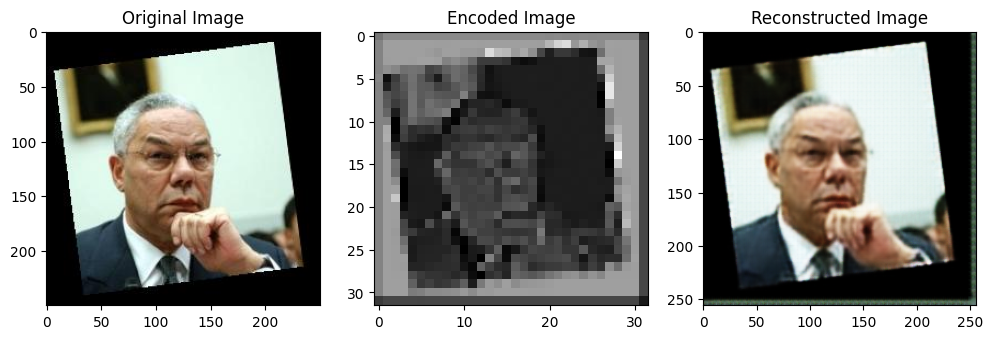

In [ ]:
# Choose a random image from the dataset
sample_image, _ = random.choice(dataloader.dataset)

# Transform and prepare the image for inference
sample_image = sample_image.unsqueeze(0).to(device)

# Generate the encoded image
encoded_image = model.encoder(sample_image)

# Choose one channel from the encoded image (you may choose a different channel)
encoded_channel = encoded_image[0, 0, :, :].cpu().detach().numpy()

# Plot the original, encoded, and reconstructed images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_image.cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(encoded_channel, cmap='gray')  # Choose one channel for visualization
plt.title("Encoded Image")

# Generate the reconstructed image
reconstructed_image = model.decoder(encoded_image)

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image.cpu().squeeze(0).permute(1, 2, 0).detach().numpy())
plt.title("Reconstructed Image")

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Ans: Adding noise to the latent representation, we essentially introduce perturbations to the learned features Consequently, this process yields a range of outcomes upon the reconstruction of the image. These outcomes may encompass minor distortions or modifications within the decoded image. The impact will depend on the scale and nature of the added noise.

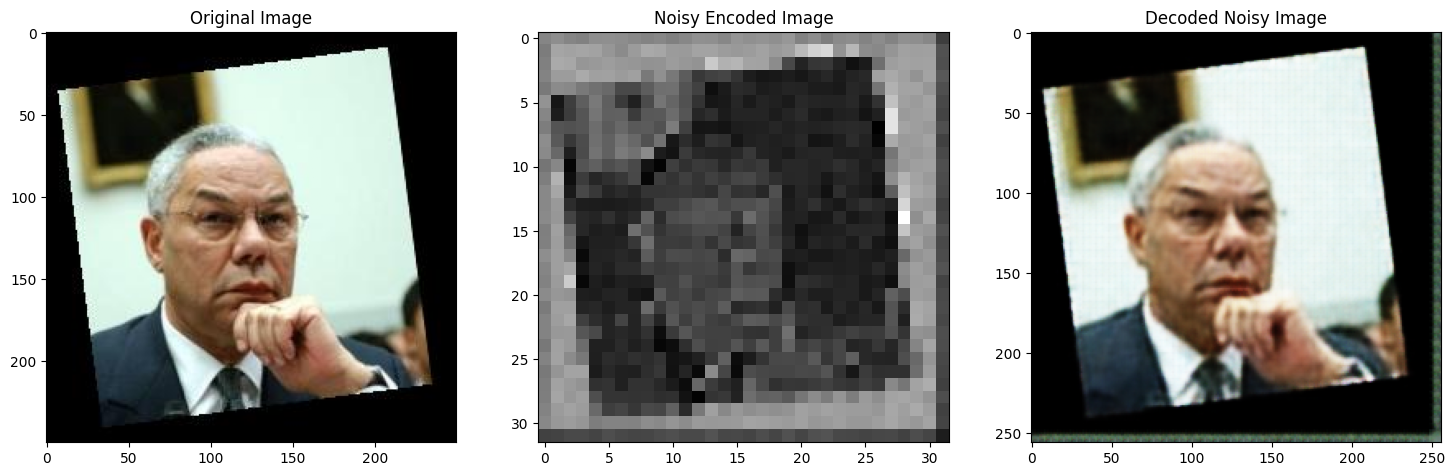

In [ ]:
# Generate the encoded image
encoded_image = model.encoder(sample_image)

# Add small normal distributed noise to the encoded image
noise = torch.randn_like(encoded_image) * 0.1  # You can adjust the scale of the noise
noisy_encoded_image = encoded_image + noise

# Decode the noisy encoded image
decoded_noisy_image = model.decoder(noisy_encoded_image)

# Plot the original, noisy encoded, and reconstructed images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(sample_image.cpu().squeeze(0).permute(1, 2, 0).numpy())
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(noisy_encoded_image[0, 0, :, :].cpu().detach().numpy(), cmap='gray')  # Choose one channel for visualization
plt.title("Noisy Encoded Image")

plt.subplot(1, 3, 3)
plt.imshow(decoded_noisy_image.cpu().squeeze(0).permute(1, 2, 0).detach().numpy())
plt.title("Decoded Noisy Image")

plt.show()
